# Pix2pix model - short preview and implementation

Author: Nikolay Chehlarov

date: January 2022

original paper: https://arxiv.org/abs/1611.07004 Image-to-Image Translation with Conditional Adversarial Networks

# Goal of the model
Given input (picture) in one modality, output in different modality is generated. Training is done on pairs of pictures in two different modalities. Example pairs include satellite image - Google maps image, day - night, sketch - bag, semantic segment mask - real image and many more. One can provide a semantic segmented mask and obtain a realistic picture for example.

An online implementation can be used https://affinelayer.com/pixsrv/ to test the approach.

![fig.1 ](figures/pix2pix_figure1.png)

# Model architecture

The pix2pix is based on conditional GAN architecture.
The main building block of the pix2pix architecture are:
- Generator: task - generate realistic looking pictures that fool the discriminator; In the case of pix2pix the generator is U-net (https://arxiv.org/abs/1505.04597)
- Discriminator: task - figure out if the image real or fake. The discriminator is convolutional patch GAN classifier, which only penalizes structure at the scale of image patches. It classifies patch by patch, finally the results are averaged.

Unlike typical cGAN, the generator accepts combination of two losses - one from the discriminator (GAN loss, binary cross entropy) and one for the difference between the generated output to the input pair (the mask). The second loss is mean absolute error, and is referred as L1 loss. In the paper the combined loss is weighted sum, with L1 having weight of 100. Unlike an unconditional GAN, both the generator and discriminator observe the input edge map.

![fig.2](figures/pix2pix_figure3.png)

The conditional GAN the loss is learned, and can, in theory, penalize any possible structure that differs between output and target. Conditional GANs learn a mapping from observed image xr and random noise vector z, to y.

# Key details from the paper

- Use of adam solver with a learning rate of 0.0002, and momentum parameters ß1 = 0.5, ß2 = 0.999
- batch size of 1 "...when the batch size is set to 1, has been termed “instance normalization” and has been demonstrated to be effective at image generation task"
- "70x70 PatchGAN forces outputs that are sharp"
- total loss = 100 x L1 + cGAN; L1 is mean absolute error and cGAN loss is binary cross entropy loss
- all activations are leaky RelU with slope 0.2
- Unlike typical approach, dropout is applied during training and testing
- batch normalization is applied using statistics on the test batch, rather than aggregated statistics on the training batch.

# Implementation

The implementation is originated from https://github.com/bnsreenu/python_for_microscopists/tree/master/251_satellite_image_to_maps_translation with minimal modifications. This source is based on Based on the code by Jason Brownlee from his blogs on https://machinelearningmastery.com/.  

The model is targeted to create maps from satellite images.
- source image is the satellite image
- target image is the maps image

Generator:  
Input - source image; Output - target image

The encoder-decoder architecture consists of:

encoder:
C64-C128-C256-C512-C512-C512-C512-C512

decoder:
CD512-CD512-CD512-C512-C256-C128-C64

Discriminator:

Input - pair of source and target image; output - probability between 0 and 1 that the inputs are actually a pair

C64-C128-C256-C512

After the last layer, a convolution is applied to map to a 1-dimensional output, followed by a Sigmoid function. 

In [1]:
from os import listdir
from datetime import datetime 
import numpy as np
from numpy import asarray, load
from numpy import vstack
from numpy import savez_compressed
from numpy.random import randint
from numpy import zeros
from numpy import ones
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

# Function definition

In [3]:
#############################################################################
#Define generator, discriminator, gan and other helper functions
#We will use functional way of defining model and not sequential
#as we have multiple inputs; both images and corresponding labels. 
########################################################################


def define_discriminator(image_shape):
    
    # weight initialization
    init = RandomNormal(stddev=0.02) #As described in the original paper
    
    # source image input
    in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
    # target image input
    in_target_image = Input(shape=image_shape)  #Image we want to generate after training. 
    
    # concatenate images, channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    
    # C64: 4x4 kernel Stride 2x2
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128: 4x4 kernel Stride 2x2
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256: 4x4 kernel Stride 2x2
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512: 4x4 kernel Stride 2x2 
    # This block is not in the original paper. 
    # d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    # d = BatchNormalization()(d)
    # d = LeakyReLU(alpha=0.2)(d)
    # second last output layer : 4x4 kernel but Stride 1x1
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    #The model is trained with a batch size of one image and Adam opt. 
    #with a small learning rate and 0.5 beta. 
    #The loss for the discriminator is weighted by 50% for each model update.
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

# disc_model = define_discriminator((256,256,3))
# disc_model.summary()

In [4]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # define an encoder block to be used in generator
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g


def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # define a decoder block to be used in generator
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g


def define_generator(image_shape=(256,256,3)):
    """
    Definint the generator, in this case U-net
    Inputs should be in the range -1 to 1; generated outputs are also in this range
    """
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    
    # bottleneck, no batch norm 
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    
    # decoder model: CD512-CD512-CD512-C512-C256-C128-C64
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) 
    out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1.
    
    # define model, without compile
    model = Model(in_image, out_image)
    return model

# gen_model = define_generator((256,256,3))
# gen_model.summary()

In [5]:
def define_gan(g_model, d_model, image_shape):
    # define the combined generator and discriminator model, for updating the generator
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but 
                                                #standalone descriminator will be trainable.
            
    # define the source image
    in_src = Input(shape=image_shape)
    # suppy the image as input to the generator 
    gen_out = g_model(in_src)
    # supply the input image and generated image as inputs to the discriminator
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and disc. output as outputs
    model = Model(in_src, [dis_out, gen_out])
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    
    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
    model.compile(loss=['binary_crossentropy', 'mae'], 
                  optimizer=opt,
                  loss_weights=[1, 100]
                 )
    return model


def generate_real_samples(dataset, n_samples, patch_shape):
    # select a batch of random samples, returns images and target
    # unpack dataset
    trainA, trainB = dataset # trainA is satellite image, trainB is coresponding maps image
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y


def generate_fake_samples(g_model, samples, patch_shape):
    # generate a batch of images, returns images and targets
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y


def summarize_performance(step, g_model, dataset, n_samples=3):
    """
    generate samples and save as a plot and save the model
    GAN models do not converge, we just want to find a good balance between
    the generator and the discriminator. Therefore, it makes sense to periodically
    save the generator model and check how good the generated image looks. 
    """
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
        
    # plot real source images
    fig = plt.figure(figsize=(10,10))
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    fig.suptitle(f'Model performance at {step+1} (src/gen/real)', fontsize=16)
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

    
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # train pix2pix models
    
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, dataset)

# Model demonstration

## Loading data

Data from: http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

Also find other datasets here: http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/

In [6]:
def load_images(path, size=(256,512)):
    """
    Load all images from a directory into memory
    """
    src_list, tar_list = list(), list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # split into satellite and map
        sat_img, map_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sat_img)
        tar_list.append(map_img)
    return [asarray(src_list), asarray(tar_list)]

# dataset path
path = 'maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


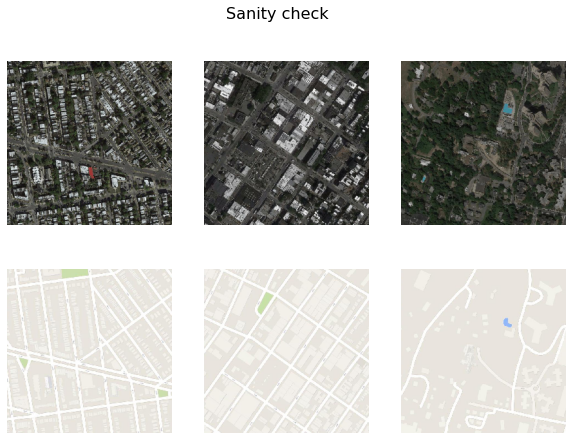

In [7]:
# sanity check for proper pair loading
n_samples = 3
fig = plt.figure(figsize=(10,7))
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(tar_images[i].astype('uint8'))
fig.suptitle('Sanity check', fontsize=16)
plt.show()

## Defining and training the model

In [8]:
# define input shape based on the loaded dataset
image_shape = src_images.shape[1:]

# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

In [9]:
# Define data
# load and prepare training images
data = [src_images, tar_images]

def preprocess_data(data):
    # load compressed arrays
    # unpack arrays
    X1, X2 = data[0], data[1]
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

dataset = preprocess_data(data)

In [10]:
start1 = datetime.now() 

train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1) 
#Reports parameters for each batch (total 1096) for each epoch.
#For 10 epochs we should see 10960

stop1 = datetime.now()
execution_time = stop1-start1
print("Execution time is: ", execution_time)

>1, d1[0.586] d2[0.452] g[79.462]
>2, d1[0.351] d2[0.473] g[66.512]
>3, d1[0.422] d2[0.425] g[77.717]
>4, d1[0.475] d2[0.404] g[74.077]
>5, d1[0.354] d2[0.413] g[71.396]
>6, d1[0.316] d2[0.384] g[70.530]
>7, d1[0.301] d2[0.342] g[69.882]
>8, d1[0.275] d2[0.395] g[64.063]
>9, d1[0.127] d2[0.413] g[48.294]
>10, d1[0.330] d2[0.242] g[61.739]
>11, d1[0.429] d2[0.330] g[48.026]
>12, d1[0.193] d2[0.263] g[56.553]
>13, d1[0.168] d2[0.246] g[51.756]
>14, d1[0.099] d2[0.223] g[48.655]
>15, d1[0.196] d2[0.213] g[46.672]
>16, d1[0.086] d2[0.178] g[41.407]
>17, d1[0.467] d2[0.416] g[33.689]
>18, d1[0.272] d2[0.506] g[27.131]
>19, d1[0.346] d2[0.201] g[35.023]
>20, d1[0.368] d2[0.216] g[32.650]
>21, d1[0.171] d2[0.288] g[30.336]
>22, d1[0.175] d2[0.249] g[27.447]
>23, d1[0.414] d2[0.209] g[21.412]
>24, d1[0.301] d2[0.657] g[20.724]
>25, d1[0.353] d2[0.123] g[24.987]
>26, d1[0.306] d2[0.525] g[19.389]
>27, d1[0.468] d2[0.562] g[18.741]
>28, d1[0.210] d2[0.227] g[21.959]
>29, d1[0.395] d2[0.247] g[22

>233, d1[0.108] d2[0.110] g[24.702]
>234, d1[0.655] d2[0.813] g[11.478]
>235, d1[0.074] d2[0.155] g[16.410]
>236, d1[0.831] d2[0.141] g[10.064]
>237, d1[0.366] d2[0.285] g[10.822]
>238, d1[0.353] d2[0.581] g[21.977]
>239, d1[0.686] d2[0.521] g[9.333]
>240, d1[0.556] d2[0.257] g[9.751]
>241, d1[0.447] d2[0.218] g[8.179]
>242, d1[0.178] d2[0.212] g[12.287]
>243, d1[0.248] d2[0.132] g[16.230]
>244, d1[0.167] d2[0.116] g[16.540]
>245, d1[0.358] d2[0.298] g[8.521]
>246, d1[0.298] d2[0.241] g[9.299]
>247, d1[0.023] d2[0.116] g[18.394]
>248, d1[0.094] d2[0.223] g[9.559]
>249, d1[0.494] d2[0.230] g[7.634]
>250, d1[0.352] d2[0.438] g[7.965]
>251, d1[0.559] d2[0.477] g[3.839]
>252, d1[0.157] d2[0.236] g[22.101]
>253, d1[0.048] d2[0.216] g[10.891]
>254, d1[0.179] d2[0.176] g[10.247]
>255, d1[0.028] d2[0.086] g[16.593]
>256, d1[0.155] d2[0.183] g[20.811]
>257, d1[0.044] d2[0.391] g[19.010]
>258, d1[0.651] d2[0.128] g[10.345]
>259, d1[0.179] d2[0.356] g[9.855]
>260, d1[0.354] d2[0.106] g[9.406]
>26

>463, d1[0.006] d2[0.216] g[17.431]
>464, d1[0.466] d2[0.159] g[14.685]
>465, d1[0.255] d2[0.229] g[9.693]
>466, d1[0.130] d2[0.161] g[9.994]
>467, d1[0.005] d2[0.314] g[16.732]
>468, d1[0.033] d2[0.133] g[11.529]
>469, d1[0.736] d2[0.143] g[8.800]
>470, d1[0.225] d2[0.239] g[9.142]
>471, d1[0.007] d2[0.185] g[13.198]
>472, d1[0.242] d2[0.166] g[9.239]
>473, d1[0.152] d2[0.169] g[8.791]
>474, d1[0.245] d2[0.184] g[9.309]
>475, d1[0.005] d2[0.190] g[17.161]
>476, d1[0.010] d2[0.081] g[15.579]
>477, d1[0.047] d2[0.102] g[18.956]
>478, d1[0.024] d2[0.067] g[18.490]
>479, d1[0.820] d2[0.284] g[9.774]
>480, d1[0.146] d2[0.172] g[11.858]
>481, d1[0.024] d2[0.304] g[19.503]
>482, d1[0.626] d2[0.108] g[10.608]
>483, d1[0.071] d2[0.207] g[11.439]
>484, d1[0.494] d2[0.237] g[8.382]
>485, d1[0.024] d2[0.113] g[9.544]
>486, d1[0.261] d2[0.187] g[8.673]
>487, d1[0.043] d2[0.124] g[20.587]
>488, d1[0.035] d2[0.164] g[17.664]
>489, d1[0.521] d2[0.142] g[8.694]
>490, d1[0.005] d2[0.276] g[29.585]
>491

>693, d1[0.170] d2[0.202] g[14.241]
>694, d1[0.155] d2[0.182] g[10.250]
>695, d1[0.012] d2[0.128] g[16.009]
>696, d1[0.277] d2[0.161] g[10.972]
>697, d1[0.146] d2[0.161] g[12.282]
>698, d1[0.008] d2[0.099] g[17.298]
>699, d1[0.291] d2[0.146] g[10.452]
>700, d1[0.037] d2[0.169] g[11.678]
>701, d1[0.363] d2[0.122] g[10.445]
>702, d1[0.112] d2[0.180] g[9.505]
>703, d1[0.007] d2[0.121] g[12.762]
>704, d1[0.257] d2[0.179] g[9.002]
>705, d1[0.519] d2[0.220] g[7.209]
>706, d1[0.088] d2[0.215] g[8.615]
>707, d1[0.009] d2[0.111] g[14.769]
>708, d1[0.162] d2[0.174] g[9.852]
>709, d1[0.281] d2[0.246] g[10.258]
>710, d1[0.137] d2[0.195] g[9.196]
>711, d1[0.226] d2[0.184] g[12.563]
>712, d1[0.023] d2[0.059] g[19.848]
>713, d1[0.255] d2[0.290] g[9.477]
>714, d1[0.155] d2[0.138] g[10.932]
>715, d1[0.077] d2[0.097] g[25.871]
>716, d1[0.003] d2[0.216] g[18.581]
>717, d1[0.761] d2[0.193] g[9.371]
>718, d1[0.166] d2[0.442] g[9.119]
>719, d1[0.258] d2[0.204] g[10.764]
>720, d1[0.114] d2[0.121] g[10.155]
>

>923, d1[0.162] d2[0.265] g[9.009]
>924, d1[0.181] d2[0.222] g[8.658]
>925, d1[0.026] d2[0.129] g[9.787]
>926, d1[0.191] d2[0.157] g[12.824]
>927, d1[0.066] d2[0.158] g[10.169]
>928, d1[0.422] d2[0.184] g[8.941]
>929, d1[0.003] d2[0.169] g[14.900]
>930, d1[0.134] d2[0.129] g[10.806]
>931, d1[0.344] d2[0.258] g[8.408]
>932, d1[0.052] d2[0.434] g[9.909]
>933, d1[0.485] d2[0.170] g[9.052]
>934, d1[0.117] d2[0.178] g[10.477]
>935, d1[0.664] d2[0.211] g[21.933]
>936, d1[0.080] d2[0.275] g[15.158]
>937, d1[0.241] d2[0.573] g[11.561]
>938, d1[0.448] d2[0.348] g[11.176]
>939, d1[0.423] d2[0.170] g[9.603]
>940, d1[0.393] d2[0.173] g[8.832]
>941, d1[0.202] d2[0.355] g[8.690]
>942, d1[0.179] d2[0.201] g[10.608]
>943, d1[0.058] d2[0.142] g[10.868]
>944, d1[0.246] d2[0.159] g[8.086]
>945, d1[0.003] d2[0.164] g[12.046]
>946, d1[0.081] d2[0.415] g[12.598]
>947, d1[0.007] d2[0.085] g[16.349]
>948, d1[0.011] d2[0.062] g[14.390]
>949, d1[0.563] d2[0.103] g[9.827]
>950, d1[0.006] d2[0.175] g[20.835]
>951

>1143, d1[0.003] d2[0.128] g[13.363]
>1144, d1[0.198] d2[0.153] g[8.616]
>1145, d1[0.282] d2[0.245] g[8.532]
>1146, d1[0.019] d2[0.184] g[15.313]
>1147, d1[0.003] d2[0.077] g[23.320]
>1148, d1[0.010] d2[0.037] g[17.991]
>1149, d1[0.029] d2[0.069] g[18.847]
>1150, d1[0.368] d2[0.202] g[11.304]
>1151, d1[0.098] d2[0.339] g[10.105]
>1152, d1[0.191] d2[0.276] g[9.338]
>1153, d1[0.086] d2[0.192] g[9.710]
>1154, d1[0.546] d2[0.207] g[10.098]
>1155, d1[0.167] d2[0.277] g[9.233]
>1156, d1[0.062] d2[0.082] g[8.408]
>1157, d1[0.457] d2[0.229] g[9.512]
>1158, d1[0.044] d2[0.128] g[13.166]
>1159, d1[0.252] d2[0.152] g[10.168]
>1160, d1[0.003] d2[0.105] g[13.730]
>1161, d1[0.681] d2[0.518] g[12.729]
>1162, d1[0.002] d2[0.130] g[13.810]
>1163, d1[0.441] d2[0.116] g[8.876]
>1164, d1[0.940] d2[0.590] g[12.376]
>1165, d1[0.235] d2[0.177] g[20.646]
>1166, d1[0.150] d2[0.373] g[8.149]
>1167, d1[0.013] d2[0.248] g[18.678]
>1168, d1[0.199] d2[0.195] g[8.906]
>1169, d1[0.004] d2[0.137] g[17.949]
>1170, d1[0

>1367, d1[0.051] d2[0.085] g[20.145]
>1368, d1[0.907] d2[0.099] g[21.907]
>1369, d1[0.326] d2[0.659] g[8.914]
>1370, d1[0.092] d2[0.104] g[16.277]
>1371, d1[0.205] d2[0.154] g[10.634]
>1372, d1[0.575] d2[0.164] g[8.941]
>1373, d1[0.756] d2[1.056] g[13.346]
>1374, d1[0.018] d2[0.160] g[9.456]
>1375, d1[0.097] d2[0.156] g[17.458]
>1376, d1[0.279] d2[0.180] g[8.218]
>1377, d1[0.007] d2[0.112] g[14.875]
>1378, d1[0.577] d2[0.169] g[8.364]
>1379, d1[0.159] d2[0.389] g[8.518]
>1380, d1[0.050] d2[0.114] g[16.232]
>1381, d1[0.184] d2[0.284] g[9.840]
>1382, d1[0.069] d2[0.081] g[11.099]
>1383, d1[0.029] d2[0.164] g[23.427]
>1384, d1[0.016] d2[0.122] g[10.191]
>1385, d1[0.428] d2[0.146] g[8.931]
>1386, d1[0.055] d2[0.182] g[9.749]
>1387, d1[0.399] d2[0.309] g[11.968]
>1388, d1[0.155] d2[0.244] g[8.466]
>1389, d1[0.287] d2[0.280] g[9.382]
>1390, d1[0.006] d2[0.115] g[11.729]
>1391, d1[0.007] d2[0.076] g[16.007]
>1392, d1[0.036] d2[0.102] g[8.693]
>1393, d1[0.679] d2[0.174] g[9.788]
>1394, d1[0.55

>1591, d1[0.116] d2[0.192] g[9.339]
>1592, d1[0.002] d2[0.118] g[12.795]
>1593, d1[0.006] d2[0.128] g[17.691]
>1594, d1[0.046] d2[0.320] g[8.605]
>1595, d1[0.014] d2[0.054] g[27.039]
>1596, d1[0.012] d2[0.041] g[20.408]
>1597, d1[0.441] d2[0.086] g[9.079]
>1598, d1[0.348] d2[0.231] g[8.321]
>1599, d1[0.150] d2[0.304] g[13.715]
>1600, d1[0.299] d2[0.140] g[12.325]
>1601, d1[0.068] d2[0.113] g[18.343]
>1602, d1[0.161] d2[0.347] g[8.095]
>1603, d1[0.048] d2[0.192] g[8.997]
>1604, d1[0.159] d2[0.149] g[9.750]
>1605, d1[0.024] d2[0.089] g[11.869]
>1606, d1[0.530] d2[0.235] g[7.533]
>1607, d1[0.090] d2[0.203] g[9.479]
>1608, d1[0.182] d2[0.215] g[8.011]
>1609, d1[0.180] d2[0.232] g[8.415]
>1610, d1[0.056] d2[0.170] g[10.311]
>1611, d1[0.065] d2[0.100] g[13.643]
>1612, d1[0.033] d2[0.076] g[13.090]
>1613, d1[0.030] d2[0.085] g[12.931]
>1614, d1[0.421] d2[0.654] g[10.606]
>1615, d1[0.914] d2[0.489] g[11.953]
>1616, d1[0.586] d2[0.186] g[9.158]
>1617, d1[0.108] d2[0.243] g[8.977]
>1618, d1[0.56

>1815, d1[0.028] d2[0.055] g[17.615]
>1816, d1[0.371] d2[0.134] g[15.895]
>1817, d1[0.595] d2[0.325] g[10.799]
>1818, d1[0.387] d2[0.259] g[9.246]
>1819, d1[0.241] d2[0.308] g[8.109]
>1820, d1[0.043] d2[0.247] g[16.303]
>1821, d1[0.026] d2[0.094] g[11.829]
>1822, d1[0.355] d2[0.411] g[7.727]
>1823, d1[0.671] d2[0.124] g[9.437]
>1824, d1[0.203] d2[0.221] g[8.653]
>1825, d1[0.074] d2[0.159] g[10.298]
>1826, d1[0.108] d2[0.161] g[8.557]
>1827, d1[0.688] d2[0.315] g[8.345]
>1828, d1[0.246] d2[0.189] g[9.701]
>1829, d1[0.248] d2[0.166] g[9.464]
>1830, d1[0.260] d2[0.268] g[9.426]
>1831, d1[0.034] d2[0.198] g[12.274]
>1832, d1[0.147] d2[0.232] g[9.505]
>1833, d1[0.077] d2[0.206] g[8.205]
>1834, d1[0.024] d2[0.095] g[15.399]
>1835, d1[0.156] d2[0.115] g[10.699]
>1836, d1[0.259] d2[0.179] g[7.633]
>1837, d1[0.073] d2[0.308] g[8.272]
>1838, d1[0.116] d2[0.178] g[8.989]
>1839, d1[0.127] d2[0.211] g[9.169]
>1840, d1[0.165] d2[0.116] g[9.400]
>1841, d1[0.009] d2[0.140] g[14.533]
>1842, d1[0.150] d

>2039, d1[0.158] d2[0.318] g[8.264]
>2040, d1[0.152] d2[0.172] g[8.346]
>2041, d1[0.232] d2[0.142] g[10.262]
>2042, d1[0.004] d2[0.171] g[16.067]
>2043, d1[0.238] d2[0.161] g[7.729]
>2044, d1[0.006] d2[0.081] g[16.615]
>2045, d1[0.204] d2[0.162] g[20.040]
>2046, d1[0.245] d2[0.638] g[10.237]
>2047, d1[0.435] d2[0.241] g[7.486]
>2048, d1[0.006] d2[0.128] g[13.409]
>2049, d1[0.103] d2[0.091] g[14.933]
>2050, d1[0.176] d2[0.139] g[8.100]
>2051, d1[0.006] d2[0.088] g[22.115]
>2052, d1[0.012] d2[0.102] g[19.357]
>2053, d1[0.078] d2[0.143] g[13.811]
>2054, d1[0.014] d2[0.163] g[16.467]
>2055, d1[0.022] d2[0.094] g[15.023]
>2056, d1[0.039] d2[0.077] g[21.851]
>2057, d1[0.789] d2[0.062] g[17.902]
>2058, d1[0.213] d2[0.109] g[17.403]
>2059, d1[0.008] d2[0.587] g[18.829]
>2060, d1[0.416] d2[0.186] g[11.627]
>2061, d1[0.558] d2[0.235] g[17.447]
>2062, d1[0.201] d2[0.354] g[10.503]
>2063, d1[0.124] d2[0.138] g[10.377]
>2064, d1[0.156] d2[0.214] g[11.781]
>2065, d1[0.391] d2[0.179] g[10.582]
>2066,

>2258, d1[0.225] d2[0.275] g[6.579]
>2259, d1[0.235] d2[0.185] g[9.713]
>2260, d1[0.259] d2[0.202] g[10.261]
>2261, d1[0.138] d2[0.293] g[10.883]
>2262, d1[0.051] d2[0.296] g[9.590]
>2263, d1[0.508] d2[0.176] g[11.206]
>2264, d1[0.396] d2[0.235] g[6.979]
>2265, d1[0.309] d2[0.163] g[11.088]
>2266, d1[0.134] d2[0.182] g[10.608]
>2267, d1[0.335] d2[0.181] g[7.488]
>2268, d1[0.122] d2[0.279] g[8.200]
>2269, d1[0.059] d2[0.167] g[14.246]
>2270, d1[0.201] d2[0.313] g[6.216]
>2271, d1[0.171] d2[0.187] g[8.430]
>2272, d1[0.039] d2[0.137] g[13.631]
>2273, d1[0.260] d2[0.288] g[9.441]
>2274, d1[0.043] d2[0.105] g[11.718]
>2275, d1[0.070] d2[0.138] g[14.704]
>2276, d1[0.317] d2[0.158] g[9.828]
>2277, d1[0.113] d2[0.293] g[8.617]
>2278, d1[0.313] d2[0.110] g[12.012]
>2279, d1[0.008] d2[0.182] g[14.263]
>2280, d1[0.105] d2[0.239] g[12.324]
>2281, d1[0.306] d2[0.182] g[8.629]
>2282, d1[0.251] d2[0.224] g[8.376]
>2283, d1[0.007] d2[0.132] g[17.752]
>2284, d1[0.014] d2[0.081] g[15.104]
>2285, d1[0.01

>2483, d1[0.063] d2[0.118] g[11.045]
>2484, d1[0.137] d2[0.343] g[9.460]
>2485, d1[0.355] d2[0.210] g[11.849]
>2486, d1[0.288] d2[0.155] g[7.945]
>2487, d1[0.033] d2[0.155] g[12.832]
>2488, d1[0.048] d2[0.142] g[5.764]
>2489, d1[0.499] d2[0.324] g[7.820]
>2490, d1[0.252] d2[0.206] g[7.879]
>2491, d1[0.070] d2[0.155] g[9.516]
>2492, d1[0.150] d2[0.204] g[7.147]
>2493, d1[0.016] d2[0.428] g[10.916]
>2494, d1[0.033] d2[0.067] g[15.824]
>2495, d1[0.428] d2[0.296] g[7.490]
>2496, d1[0.011] d2[0.104] g[23.458]
>2497, d1[0.146] d2[0.176] g[11.537]
>2498, d1[0.014] d2[0.109] g[20.282]
>2499, d1[0.014] d2[0.105] g[17.650]
>2500, d1[0.012] d2[0.087] g[19.502]
>2501, d1[0.013] d2[0.076] g[15.536]
>2502, d1[0.657] d2[0.099] g[12.076]
>2503, d1[0.436] d2[0.577] g[11.980]
>2504, d1[0.421] d2[0.153] g[9.751]
>2505, d1[0.231] d2[0.329] g[8.151]
>2506, d1[0.130] d2[0.243] g[8.334]
>2507, d1[0.210] d2[0.160] g[9.531]
>2508, d1[0.076] d2[0.239] g[7.808]
>2509, d1[0.243] d2[0.182] g[8.791]
>2510, d1[0.166

>2708, d1[0.568] d2[0.262] g[8.480]
>2709, d1[0.011] d2[0.077] g[12.977]
>2710, d1[0.315] d2[0.173] g[7.979]
>2711, d1[0.167] d2[0.420] g[8.517]
>2712, d1[0.390] d2[0.205] g[10.000]
>2713, d1[0.238] d2[0.276] g[8.872]
>2714, d1[0.023] d2[0.153] g[9.909]
>2715, d1[0.016] d2[0.091] g[12.810]
>2716, d1[0.556] d2[0.155] g[16.542]
>2717, d1[0.354] d2[0.433] g[8.660]
>2718, d1[0.359] d2[0.390] g[7.575]
>2719, d1[0.042] d2[0.093] g[11.718]
>2720, d1[0.039] d2[0.191] g[9.849]
>2721, d1[0.027] d2[0.089] g[14.915]
>2722, d1[0.351] d2[0.151] g[9.435]
>2723, d1[0.115] d2[0.182] g[12.562]
>2724, d1[0.026] d2[0.122] g[22.136]
>2725, d1[0.014] d2[0.231] g[12.437]
>2726, d1[0.063] d2[0.092] g[15.967]
>2727, d1[0.721] d2[0.126] g[9.618]
>2728, d1[0.336] d2[0.365] g[11.534]
>2729, d1[0.222] d2[0.340] g[8.234]
>2730, d1[0.203] d2[0.147] g[7.847]
>2731, d1[0.241] d2[0.178] g[7.999]
>2732, d1[0.220] d2[0.229] g[7.316]
>2733, d1[0.012] d2[0.120] g[14.160]
>2734, d1[0.232] d2[0.252] g[12.332]
>2735, d1[0.149

>2933, d1[0.283] d2[0.333] g[8.296]
>2934, d1[0.035] d2[0.149] g[11.505]
>2935, d1[0.011] d2[0.084] g[13.179]
>2936, d1[0.594] d2[0.152] g[7.879]
>2937, d1[0.029] d2[0.191] g[9.824]
>2938, d1[0.313] d2[0.188] g[9.556]
>2939, d1[0.155] d2[0.320] g[10.656]
>2940, d1[0.786] d2[0.124] g[20.287]
>2941, d1[0.054] d2[0.582] g[8.529]
>2942, d1[0.264] d2[0.181] g[8.174]
>2943, d1[0.228] d2[0.174] g[7.300]
>2944, d1[0.009] d2[0.137] g[13.268]
>2945, d1[0.455] d2[0.290] g[9.312]
>2946, d1[0.009] d2[0.168] g[12.252]
>2947, d1[0.242] d2[0.325] g[9.509]
>2948, d1[0.228] d2[0.132] g[8.576]
>2949, d1[0.014] d2[0.092] g[12.696]
>2950, d1[0.014] d2[0.317] g[17.031]
>2951, d1[0.603] d2[0.296] g[12.537]
>2952, d1[0.018] d2[0.137] g[14.672]
>2953, d1[0.613] d2[0.165] g[9.583]
>2954, d1[0.248] d2[0.233] g[9.286]
>2955, d1[0.375] d2[0.200] g[12.729]
>2956, d1[0.100] d2[0.230] g[14.995]
>2957, d1[0.018] d2[0.173] g[16.321]
>2958, d1[0.342] d2[0.188] g[8.988]
>2959, d1[0.016] d2[0.084] g[14.659]
>2960, d1[0.00

>3158, d1[0.030] d2[0.124] g[11.748]
>3159, d1[0.015] d2[0.165] g[11.234]
>3160, d1[0.043] d2[0.076] g[18.636]
>3161, d1[0.016] d2[0.071] g[12.238]
>3162, d1[0.028] d2[0.066] g[10.392]
>3163, d1[0.911] d2[0.087] g[8.928]
>3164, d1[0.240] d2[0.410] g[10.071]
>3165, d1[0.720] d2[0.382] g[13.999]
>3166, d1[0.210] d2[0.161] g[7.416]
>3167, d1[0.388] d2[0.319] g[14.743]
>3168, d1[0.281] d2[0.316] g[7.390]
>3169, d1[0.117] d2[0.334] g[7.210]
>3170, d1[0.103] d2[0.183] g[10.432]
>3171, d1[0.048] d2[0.187] g[21.779]
>3172, d1[0.500] d2[0.140] g[10.286]
>3173, d1[0.369] d2[0.283] g[8.361]
>3174, d1[0.103] d2[0.299] g[7.931]
>3175, d1[0.012] d2[0.151] g[15.874]
>3176, d1[0.294] d2[0.116] g[8.758]
>3177, d1[0.172] d2[0.616] g[5.673]
>3178, d1[0.154] d2[0.110] g[9.516]
>3179, d1[0.063] d2[0.122] g[17.399]
>3180, d1[0.367] d2[0.238] g[10.143]
>3181, d1[0.324] d2[0.132] g[16.555]
>3182, d1[0.133] d2[0.398] g[8.717]
>3183, d1[0.098] d2[0.148] g[10.572]
>3184, d1[0.063] d2[0.108] g[13.634]
>3185, d1[0

>3377, d1[0.150] d2[0.297] g[8.676]
>3378, d1[0.017] d2[0.091] g[17.498]
>3379, d1[0.027] d2[0.059] g[13.175]
>3380, d1[0.185] d2[0.215] g[8.354]
>3381, d1[0.536] d2[0.156] g[7.513]
>3382, d1[0.150] d2[0.184] g[9.587]
>3383, d1[0.061] d2[0.097] g[12.856]
>3384, d1[0.012] d2[0.090] g[13.646]
>3385, d1[0.022] d2[0.194] g[12.675]
>3386, d1[0.445] d2[0.413] g[8.011]
>3387, d1[0.044] d2[0.202] g[5.675]
>3388, d1[0.375] d2[0.097] g[10.623]
>3389, d1[0.018] d2[0.158] g[13.181]
>3390, d1[0.013] d2[0.066] g[14.390]
>3391, d1[0.411] d2[0.306] g[11.247]
>3392, d1[0.434] d2[0.473] g[9.059]
>3393, d1[0.361] d2[0.292] g[9.966]
>3394, d1[0.090] d2[0.186] g[16.162]
>3395, d1[0.448] d2[0.240] g[7.534]
>3396, d1[0.332] d2[0.877] g[8.894]
>3397, d1[0.397] d2[0.370] g[9.244]
>3398, d1[0.394] d2[0.230] g[10.006]
>3399, d1[0.554] d2[0.551] g[7.553]
>3400, d1[0.212] d2[0.239] g[8.865]
>3401, d1[0.222] d2[0.404] g[7.276]
>3402, d1[0.038] d2[0.092] g[13.533]
>3403, d1[0.826] d2[0.256] g[6.837]
>3404, d1[0.454]

>3602, d1[0.029] d2[0.088] g[10.825]
>3603, d1[0.020] d2[0.080] g[11.400]
>3604, d1[0.010] d2[0.064] g[21.460]
>3605, d1[0.369] d2[0.096] g[10.892]
>3606, d1[0.123] d2[0.326] g[7.664]
>3607, d1[0.042] d2[0.101] g[8.787]
>3608, d1[0.211] d2[0.138] g[12.021]
>3609, d1[0.291] d2[0.634] g[11.137]
>3610, d1[0.041] d2[0.115] g[15.314]
>3611, d1[0.064] d2[0.194] g[13.508]
>3612, d1[0.273] d2[0.289] g[6.288]
>3613, d1[0.039] d2[0.057] g[13.870]
>3614, d1[0.604] d2[0.099] g[8.249]
>3615, d1[0.023] d2[0.147] g[9.823]
>3616, d1[0.022] d2[0.191] g[12.003]
>3617, d1[0.032] d2[0.082] g[11.921]
>3618, d1[0.030] d2[0.065] g[18.146]
>3619, d1[0.262] d2[0.163] g[8.643]
>3620, d1[0.012] d2[0.057] g[17.671]
>3621, d1[0.296] d2[0.165] g[10.429]
>3622, d1[0.167] d2[0.247] g[9.870]
>3623, d1[0.057] d2[0.149] g[6.764]
>3624, d1[0.015] d2[0.155] g[12.037]
>3625, d1[0.036] d2[0.066] g[14.656]
>3626, d1[0.160] d2[0.077] g[14.464]
>3627, d1[0.227] d2[0.207] g[8.821]
>3628, d1[0.114] d2[0.504] g[6.630]
>3629, d1[0

>3827, d1[0.364] d2[0.140] g[11.735]
>3828, d1[0.182] d2[0.314] g[8.987]
>3829, d1[0.137] d2[0.259] g[7.479]
>3830, d1[0.144] d2[0.145] g[8.889]
>3831, d1[0.171] d2[0.324] g[7.412]
>3832, d1[0.071] d2[0.118] g[9.496]
>3833, d1[0.463] d2[0.254] g[7.088]
>3834, d1[0.026] d2[0.171] g[13.422]
>3835, d1[0.245] d2[0.237] g[10.504]
>3836, d1[0.041] d2[0.112] g[10.116]
>3837, d1[0.543] d2[0.170] g[8.787]
>3838, d1[0.092] d2[0.285] g[10.705]
>3839, d1[0.126] d2[0.318] g[9.581]
>3840, d1[0.035] d2[0.178] g[12.129]
>3841, d1[0.538] d2[0.102] g[9.276]
>3842, d1[0.326] d2[0.218] g[8.477]
>3843, d1[0.082] d2[0.165] g[8.872]
>3844, d1[0.110] d2[0.146] g[7.846]
>3845, d1[0.201] d2[0.557] g[7.983]
>3846, d1[0.052] d2[0.205] g[14.896]
>3847, d1[0.249] d2[0.098] g[11.695]
>3848, d1[0.202] d2[0.169] g[8.363]
>3849, d1[0.062] d2[0.257] g[4.975]
>3850, d1[0.024] d2[0.088] g[18.116]
>3851, d1[0.031] d2[0.061] g[14.802]
>3852, d1[0.038] d2[0.084] g[12.113]
>3853, d1[0.018] d2[0.064] g[27.685]
>3854, d1[0.274]

>4052, d1[0.178] d2[0.212] g[9.683]
>4053, d1[0.070] d2[0.225] g[9.018]
>4054, d1[0.093] d2[0.125] g[12.536]
>4055, d1[0.285] d2[0.102] g[8.134]
>4056, d1[0.070] d2[0.120] g[13.935]
>4057, d1[0.016] d2[0.348] g[14.189]
>4058, d1[0.270] d2[0.101] g[12.963]
>4059, d1[0.114] d2[0.155] g[8.333]
>4060, d1[0.133] d2[0.146] g[8.416]
>4061, d1[0.305] d2[0.203] g[10.946]
>4062, d1[0.072] d2[0.261] g[7.243]
>4063, d1[0.058] d2[0.081] g[14.870]
>4064, d1[0.200] d2[0.114] g[13.287]
>4065, d1[0.074] d2[0.242] g[10.297]
>4066, d1[0.082] d2[0.126] g[11.677]
>4067, d1[0.016] d2[0.103] g[13.697]
>4068, d1[0.074] d2[0.101] g[11.208]
>4069, d1[0.189] d2[0.317] g[5.125]
>4070, d1[0.346] d2[0.112] g[9.888]
>4071, d1[0.045] d2[0.160] g[11.152]
>4072, d1[0.072] d2[0.061] g[6.440]
>4073, d1[0.272] d2[0.167] g[7.310]
>4074, d1[0.100] d2[0.177] g[7.863]
>4075, d1[0.323] d2[0.338] g[8.292]
>4076, d1[0.019] d2[0.175] g[13.970]
>4077, d1[0.079] d2[0.163] g[4.855]
>4078, d1[0.222] d2[0.163] g[9.119]
>4079, d1[0.013

>4277, d1[0.217] d2[0.197] g[9.407]
>4278, d1[0.269] d2[0.185] g[17.151]
>4279, d1[0.149] d2[0.397] g[8.225]
>4280, d1[0.174] d2[0.357] g[7.833]
>4281, d1[0.629] d2[0.143] g[13.551]
>4282, d1[0.112] d2[0.127] g[10.393]
>4283, d1[0.278] d2[0.539] g[7.688]
>4284, d1[0.264] d2[0.196] g[8.726]
>4285, d1[0.005] d2[0.433] g[19.775]
>4286, d1[0.601] d2[0.110] g[12.438]
>4287, d1[0.387] d2[0.114] g[12.940]
>4288, d1[0.028] d2[0.261] g[11.511]
>4289, d1[0.050] d2[0.159] g[10.523]
>4290, d1[0.181] d2[0.147] g[9.787]
>4291, d1[0.235] d2[0.204] g[7.059]
>4292, d1[0.066] d2[0.284] g[7.065]
>4293, d1[0.043] d2[0.097] g[10.768]
>4294, d1[0.363] d2[0.090] g[8.726]
>4295, d1[0.034] d2[0.087] g[16.089]
>4296, d1[0.051] d2[0.128] g[8.430]
>4297, d1[0.172] d2[0.321] g[10.182]
>4298, d1[0.092] d2[0.151] g[7.709]
>4299, d1[0.154] d2[0.150] g[8.984]
>4300, d1[0.013] d2[0.098] g[17.539]
>4301, d1[0.606] d2[0.118] g[15.378]
>4302, d1[0.105] d2[0.139] g[9.358]
>4303, d1[0.119] d2[0.292] g[9.212]
>4304, d1[0.007

>4496, d1[0.099] d2[0.153] g[7.788]
>4497, d1[0.373] d2[0.168] g[8.607]
>4498, d1[0.106] d2[0.236] g[10.510]
>4499, d1[0.053] d2[0.095] g[9.382]
>4500, d1[0.040] d2[0.241] g[11.973]
>4501, d1[0.227] d2[0.137] g[8.446]
>4502, d1[0.204] d2[0.133] g[10.955]
>4503, d1[0.283] d2[0.188] g[9.736]
>4504, d1[0.050] d2[0.228] g[11.168]
>4505, d1[0.111] d2[0.111] g[8.940]
>4506, d1[0.214] d2[0.207] g[7.049]
>4507, d1[0.219] d2[0.188] g[8.626]
>4508, d1[0.091] d2[0.152] g[11.069]
>4509, d1[0.019] d2[0.133] g[18.702]
>4510, d1[0.122] d2[0.094] g[4.782]
>4511, d1[0.129] d2[0.150] g[9.369]
>4512, d1[0.096] d2[0.131] g[8.610]
>4513, d1[0.180] d2[0.211] g[11.430]
>4514, d1[0.266] d2[0.096] g[7.732]
>4515, d1[0.257] d2[0.425] g[8.572]
>4516, d1[0.461] d2[0.248] g[9.520]
>4517, d1[0.030] d2[0.351] g[14.831]
>4518, d1[0.026] d2[0.135] g[13.173]
>4519, d1[0.646] d2[0.417] g[11.025]
>4520, d1[0.611] d2[0.591] g[10.932]
>4521, d1[0.453] d2[0.224] g[11.203]
>4522, d1[0.171] d2[0.202] g[10.543]
>4523, d1[0.293

>4721, d1[0.269] d2[0.448] g[7.654]
>4722, d1[0.597] d2[0.340] g[8.708]
>4723, d1[0.463] d2[0.160] g[8.821]
>4724, d1[0.073] d2[0.229] g[9.896]
>4725, d1[0.069] d2[0.105] g[10.374]
>4726, d1[0.280] d2[0.141] g[7.746]
>4727, d1[0.198] d2[0.276] g[7.949]
>4728, d1[0.213] d2[0.360] g[7.569]
>4729, d1[0.015] d2[0.111] g[12.297]
>4730, d1[0.030] d2[0.218] g[13.030]
>4731, d1[0.409] d2[0.206] g[7.008]
>4732, d1[0.202] d2[0.154] g[8.001]
>4733, d1[0.315] d2[0.454] g[6.708]
>4734, d1[0.013] d2[0.108] g[11.124]
>4735, d1[0.018] d2[0.113] g[13.216]
>4736, d1[0.006] d2[0.119] g[25.951]
>4737, d1[0.533] d2[0.167] g[8.604]
>4738, d1[0.215] d2[0.319] g[8.280]
>4739, d1[0.095] d2[0.178] g[9.743]
>4740, d1[0.113] d2[0.116] g[10.695]
>4741, d1[0.116] d2[0.172] g[6.391]
>4742, d1[0.039] d2[0.112] g[11.336]
>4743, d1[0.062] d2[0.075] g[10.422]
>4744, d1[0.009] d2[0.068] g[16.272]
>4745, d1[0.021] d2[0.061] g[10.424]
>4746, d1[0.021] d2[0.080] g[14.459]
>4747, d1[0.363] d2[0.151] g[8.412]
>4748, d1[0.238]

>4947, d1[0.454] d2[0.299] g[4.882]
>4948, d1[0.011] d2[0.218] g[11.432]
>4949, d1[0.307] d2[0.192] g[7.833]
>4950, d1[0.130] d2[0.189] g[7.637]
>4951, d1[0.151] d2[0.168] g[8.355]
>4952, d1[0.080] d2[0.130] g[11.223]
>4953, d1[0.147] d2[0.161] g[8.214]
>4954, d1[0.010] d2[0.093] g[16.923]
>4955, d1[0.201] d2[0.202] g[8.498]
>4956, d1[0.121] d2[0.466] g[8.284]
>4957, d1[0.118] d2[0.140] g[9.871]
>4958, d1[0.277] d2[0.555] g[8.399]
>4959, d1[0.149] d2[0.112] g[5.465]
>4960, d1[0.417] d2[0.210] g[7.435]
>4961, d1[0.477] d2[0.388] g[8.411]
>4962, d1[0.128] d2[0.177] g[8.788]
>4963, d1[0.408] d2[0.314] g[8.921]
>4964, d1[0.057] d2[0.331] g[4.696]
>4965, d1[0.563] d2[0.324] g[5.168]
>4966, d1[0.340] d2[0.244] g[7.580]
>4967, d1[0.036] d2[0.243] g[8.722]
>4968, d1[0.053] d2[0.127] g[12.863]
>4969, d1[0.420] d2[0.200] g[7.495]
>4970, d1[0.109] d2[0.211] g[11.790]
>4971, d1[0.318] d2[0.157] g[10.389]
>4972, d1[0.170] d2[0.159] g[7.683]
>4973, d1[0.009] d2[0.129] g[17.771]
>4974, d1[0.194] d2[0

>5173, d1[0.061] d2[0.068] g[13.155]
>5174, d1[0.403] d2[0.274] g[7.559]
>5175, d1[0.151] d2[0.233] g[8.741]
>5176, d1[0.125] d2[0.153] g[8.617]
>5177, d1[0.014] d2[0.089] g[13.377]
>5178, d1[0.399] d2[0.170] g[6.790]
>5179, d1[0.049] d2[0.111] g[9.852]
>5180, d1[0.408] d2[0.269] g[7.437]
>5181, d1[0.022] d2[0.167] g[10.716]
>5182, d1[0.116] d2[0.362] g[6.745]
>5183, d1[0.421] d2[0.315] g[8.483]
>5184, d1[0.292] d2[0.349] g[10.876]
>5185, d1[0.204] d2[0.219] g[8.641]
>5186, d1[0.238] d2[0.146] g[9.740]
>5187, d1[0.116] d2[0.057] g[7.091]
>5188, d1[0.006] d2[0.131] g[13.056]
>5189, d1[0.190] d2[0.241] g[7.568]
>5190, d1[0.015] d2[0.071] g[21.034]
>5191, d1[0.563] d2[0.522] g[5.424]
>5192, d1[0.006] d2[0.093] g[21.039]
>5193, d1[0.483] d2[0.185] g[8.634]
>5194, d1[0.138] d2[0.288] g[9.574]
>5195, d1[0.285] d2[0.288] g[8.307]
>5196, d1[0.213] d2[0.284] g[8.115]
>5197, d1[0.012] d2[0.070] g[13.033]
>5198, d1[0.662] d2[0.213] g[7.235]
>5199, d1[0.056] d2[0.127] g[12.610]
>5200, d1[0.011] d2

>5399, d1[0.199] d2[0.477] g[9.087]
>5400, d1[0.134] d2[0.177] g[9.765]
>5401, d1[0.142] d2[0.158] g[6.596]
>5402, d1[0.167] d2[0.159] g[11.167]
>5403, d1[0.043] d2[0.093] g[4.835]
>5404, d1[0.010] d2[0.086] g[16.893]
>5405, d1[0.270] d2[0.217] g[7.953]
>5406, d1[0.093] d2[0.182] g[7.219]
>5407, d1[0.099] d2[0.163] g[8.522]
>5408, d1[0.086] d2[0.169] g[9.788]
>5409, d1[0.015] d2[0.091] g[12.066]
>5410, d1[0.362] d2[0.123] g[7.048]
>5411, d1[0.019] d2[0.113] g[12.435]
>5412, d1[0.197] d2[0.170] g[8.668]
>5413, d1[0.040] d2[0.146] g[4.639]
>5414, d1[0.303] d2[0.157] g[7.464]
>5415, d1[0.461] d2[0.413] g[6.971]
>5416, d1[0.141] d2[0.203] g[9.950]
>5417, d1[0.036] d2[0.205] g[12.937]
>5418, d1[0.194] d2[0.157] g[8.098]
>5419, d1[0.150] d2[0.267] g[7.840]
>5420, d1[0.574] d2[0.189] g[9.594]
>5421, d1[0.112] d2[0.282] g[8.696]
>5422, d1[0.127] d2[0.488] g[11.905]
>5423, d1[0.430] d2[0.147] g[8.773]
>5424, d1[0.224] d2[0.106] g[8.989]
>5425, d1[0.152] d2[0.289] g[7.089]
>5426, d1[0.270] d2[0.

>5618, d1[0.242] d2[0.246] g[7.350]
>5619, d1[0.016] d2[0.132] g[15.412]
>5620, d1[0.019] d2[0.284] g[13.623]
>5621, d1[0.369] d2[0.070] g[9.691]
>5622, d1[0.047] d2[0.084] g[12.163]
>5623, d1[0.333] d2[0.118] g[7.926]
>5624, d1[0.130] d2[0.507] g[9.307]
>5625, d1[0.151] d2[0.143] g[10.362]
>5626, d1[0.070] d2[0.103] g[9.867]
>5627, d1[0.360] d2[0.061] g[4.391]
>5628, d1[0.262] d2[0.494] g[7.409]
>5629, d1[0.254] d2[0.304] g[9.117]
>5630, d1[0.006] d2[0.112] g[14.983]
>5631, d1[0.477] d2[0.201] g[8.731]
>5632, d1[0.065] d2[0.106] g[5.464]
>5633, d1[0.492] d2[0.186] g[11.690]
>5634, d1[0.202] d2[0.335] g[7.459]
>5635, d1[0.348] d2[0.248] g[7.898]
>5636, d1[0.010] d2[0.157] g[14.555]
>5637, d1[0.101] d2[0.278] g[7.721]
>5638, d1[0.061] d2[0.075] g[10.206]
>5639, d1[0.168] d2[0.253] g[6.016]
>5640, d1[0.162] d2[0.618] g[6.227]
>5641, d1[0.667] d2[0.218] g[7.584]
>5642, d1[0.341] d2[0.270] g[7.141]
>5643, d1[0.534] d2[0.275] g[8.555]
>5644, d1[0.170] d2[0.191] g[8.475]
>5645, d1[0.903] d2[

>5844, d1[0.021] d2[0.138] g[12.306]
>5845, d1[0.074] d2[0.159] g[10.786]
>5846, d1[0.629] d2[0.088] g[8.513]
>5847, d1[0.105] d2[0.232] g[10.707]
>5848, d1[0.052] d2[0.075] g[9.538]
>5849, d1[0.301] d2[0.314] g[5.853]
>5850, d1[0.058] d2[0.147] g[9.857]
>5851, d1[0.046] d2[0.124] g[9.529]
>5852, d1[0.245] d2[0.250] g[10.315]
>5853, d1[0.087] d2[0.109] g[8.134]
>5854, d1[0.244] d2[0.166] g[9.719]
>5855, d1[0.053] d2[0.124] g[12.120]
>5856, d1[0.112] d2[0.288] g[8.072]
>5857, d1[0.147] d2[0.117] g[15.776]
>5858, d1[0.204] d2[0.308] g[8.155]
>5859, d1[0.030] d2[0.090] g[11.610]
>5860, d1[0.073] d2[0.135] g[10.381]
>5861, d1[0.187] d2[0.113] g[8.602]
>5862, d1[0.369] d2[0.297] g[7.906]
>5863, d1[0.389] d2[0.365] g[6.847]
>5864, d1[0.013] d2[0.191] g[10.782]
>5865, d1[0.043] d2[0.071] g[13.550]
>5866, d1[0.826] d2[0.438] g[9.525]
>5867, d1[0.019] d2[0.186] g[14.098]
>5868, d1[0.274] d2[0.152] g[8.283]
>5869, d1[0.648] d2[0.419] g[6.195]
>5870, d1[0.038] d2[0.229] g[11.267]
>5871, d1[0.906]

>6070, d1[0.070] d2[0.220] g[8.232]
>6071, d1[0.327] d2[0.104] g[10.836]
>6072, d1[0.048] d2[0.179] g[11.136]
>6073, d1[0.033] d2[0.054] g[21.290]
>6074, d1[0.114] d2[0.043] g[6.873]
>6075, d1[0.196] d2[0.107] g[7.234]
>6076, d1[0.009] d2[0.220] g[10.461]
>6077, d1[0.110] d2[0.092] g[4.604]
>6078, d1[0.283] d2[0.227] g[12.159]
>6079, d1[0.064] d2[0.105] g[9.762]
>6080, d1[0.239] d2[0.530] g[6.606]
>6081, d1[0.087] d2[0.115] g[12.308]
>6082, d1[0.284] d2[0.225] g[9.612]
>6083, d1[0.266] d2[0.187] g[7.617]
>6084, d1[0.088] d2[0.050] g[4.833]
>6085, d1[0.183] d2[0.366] g[5.208]
>6086, d1[0.095] d2[0.071] g[11.314]
>6087, d1[0.277] d2[0.420] g[8.053]
>6088, d1[0.253] d2[0.206] g[8.740]
>6089, d1[0.266] d2[0.236] g[7.562]
>6090, d1[0.141] d2[0.124] g[8.681]
>6091, d1[0.017] d2[0.313] g[10.445]
>6092, d1[0.246] d2[0.135] g[8.451]
>6093, d1[0.003] d2[0.099] g[15.774]
>6094, d1[0.292] d2[0.361] g[9.802]
>6095, d1[0.561] d2[0.275] g[7.318]
>6096, d1[0.103] d2[0.231] g[8.428]
>6097, d1[0.154] d2

>6296, d1[0.228] d2[0.202] g[8.934]
>6297, d1[0.317] d2[0.282] g[12.217]
>6298, d1[0.215] d2[0.321] g[6.039]
>6299, d1[0.022] d2[0.227] g[13.838]
>6300, d1[0.337] d2[0.169] g[5.696]
>6301, d1[0.405] d2[0.241] g[9.022]
>6302, d1[0.116] d2[0.205] g[7.516]
>6303, d1[0.051] d2[0.121] g[10.818]
>6304, d1[0.082] d2[0.080] g[4.418]
>6305, d1[0.058] d2[0.072] g[15.599]
>6306, d1[0.143] d2[0.293] g[8.580]
>6307, d1[0.133] d2[0.171] g[8.520]
>6308, d1[0.142] d2[0.079] g[9.892]
>6309, d1[0.053] d2[0.083] g[8.519]
>6310, d1[0.208] d2[0.221] g[9.055]
>6311, d1[0.013] d2[0.102] g[13.427]
>6312, d1[0.068] d2[0.064] g[14.549]
>6313, d1[0.129] d2[0.215] g[7.735]
>6314, d1[0.262] d2[0.094] g[13.791]
>6315, d1[0.061] d2[0.196] g[8.456]
>6316, d1[0.074] d2[0.243] g[7.814]
>6317, d1[0.004] d2[0.127] g[13.644]
>6318, d1[0.010] d2[0.056] g[16.064]
>6319, d1[0.010] d2[0.086] g[16.015]
>6320, d1[0.211] d2[0.141] g[9.930]
>6321, d1[0.147] d2[0.064] g[9.988]
>6322, d1[0.014] d2[0.219] g[11.371]
>6323, d1[0.196] 

>6522, d1[0.129] d2[0.164] g[10.065]
>6523, d1[0.169] d2[0.136] g[11.239]
>6524, d1[0.529] d2[0.228] g[5.897]
>6525, d1[0.189] d2[0.176] g[9.043]
>6526, d1[0.307] d2[0.168] g[9.559]
>6527, d1[0.112] d2[0.307] g[6.726]
>6528, d1[0.092] d2[0.159] g[8.992]
>6529, d1[0.328] d2[0.247] g[6.971]
>6530, d1[0.303] d2[0.197] g[6.992]
>6531, d1[0.214] d2[0.360] g[8.814]
>6532, d1[0.097] d2[0.200] g[7.904]
>6533, d1[0.008] d2[0.113] g[12.608]
>6534, d1[0.073] d2[0.265] g[9.347]
>6535, d1[0.470] d2[0.676] g[5.590]
>6536, d1[0.032] d2[0.111] g[12.869]
>6537, d1[0.042] d2[0.127] g[14.693]
>6538, d1[0.016] d2[0.072] g[15.064]
>6539, d1[0.385] d2[0.140] g[8.069]
>6540, d1[0.008] d2[0.097] g[15.264]
>6541, d1[0.170] d2[0.213] g[8.850]
>6542, d1[0.105] d2[0.309] g[11.103]
>6543, d1[0.190] d2[0.085] g[10.444]
>6544, d1[0.119] d2[0.052] g[16.843]
>6545, d1[0.396] d2[0.139] g[8.582]
>6546, d1[0.198] d2[0.383] g[9.249]
>6547, d1[0.067] d2[0.219] g[8.785]
>6548, d1[0.199] d2[0.168] g[7.998]
>6549, d1[0.678] d

>6742, d1[0.098] d2[0.089] g[11.705]
>6743, d1[0.019] d2[0.367] g[12.758]
>6744, d1[0.043] d2[0.045] g[13.715]
>6745, d1[0.442] d2[0.169] g[7.233]
>6746, d1[0.163] d2[0.040] g[12.193]
>6747, d1[0.171] d2[0.140] g[7.017]
>6748, d1[0.051] d2[0.101] g[8.772]
>6749, d1[0.045] d2[0.077] g[15.702]
>6750, d1[0.102] d2[0.306] g[10.287]
>6751, d1[0.014] d2[0.154] g[16.090]
>6752, d1[0.157] d2[0.271] g[4.476]
>6753, d1[0.109] d2[0.081] g[10.432]
>6754, d1[0.229] d2[0.153] g[7.701]
>6755, d1[1.146] d2[0.070] g[14.088]
>6756, d1[0.073] d2[0.295] g[8.864]
>6757, d1[0.138] d2[0.117] g[8.118]
>6758, d1[0.130] d2[0.261] g[8.595]
>6759, d1[0.131] d2[0.111] g[9.803]
>6760, d1[0.049] d2[0.214] g[16.317]
>6761, d1[0.005] d2[0.234] g[17.054]
>6762, d1[0.108] d2[0.077] g[10.616]
>6763, d1[0.145] d2[0.098] g[13.195]
>6764, d1[0.126] d2[0.118] g[9.424]
>6765, d1[0.183] d2[0.149] g[9.590]
>6766, d1[0.020] d2[0.217] g[15.188]
>6767, d1[0.213] d2[0.524] g[7.045]
>6768, d1[0.183] d2[0.650] g[13.461]
>6769, d1[0.0

>6967, d1[0.543] d2[0.247] g[7.695]
>6968, d1[0.039] d2[0.095] g[9.978]
>6969, d1[0.094] d2[0.282] g[4.673]
>6970, d1[0.653] d2[0.147] g[10.435]
>6971, d1[0.368] d2[0.319] g[8.101]
>6972, d1[0.071] d2[0.455] g[7.422]
>6973, d1[0.315] d2[0.151] g[9.350]
>6974, d1[0.118] d2[0.099] g[12.332]
>6975, d1[0.285] d2[0.236] g[8.220]
>6976, d1[0.910] d2[0.240] g[6.789]
>6977, d1[0.066] d2[0.170] g[8.715]
>6978, d1[0.154] d2[0.376] g[6.946]
>6979, d1[0.005] d2[0.118] g[13.371]
>6980, d1[0.259] d2[0.143] g[8.352]
>6981, d1[0.009] d2[0.144] g[19.110]
>6982, d1[0.141] d2[0.199] g[9.181]
>6983, d1[0.010] d2[0.115] g[12.737]
>6984, d1[0.210] d2[0.105] g[9.462]
>6985, d1[0.004] d2[0.105] g[14.623]
>6986, d1[0.113] d2[0.077] g[10.812]
>6987, d1[0.499] d2[0.374] g[14.072]
>6988, d1[0.091] d2[0.494] g[10.198]
>6989, d1[0.558] d2[0.221] g[7.505]
>6990, d1[0.282] d2[0.288] g[7.174]
>6991, d1[0.023] d2[0.150] g[13.321]
>6992, d1[0.190] d2[0.384] g[6.017]
>6993, d1[0.037] d2[0.125] g[12.671]
>6994, d1[0.201] 

>7193, d1[0.300] d2[0.206] g[8.009]
>7194, d1[0.098] d2[0.168] g[8.659]
>7195, d1[0.024] d2[0.124] g[13.543]
>7196, d1[0.049] d2[0.100] g[9.511]
>7197, d1[0.151] d2[0.329] g[7.167]
>7198, d1[0.465] d2[0.300] g[8.005]
>7199, d1[0.011] d2[0.390] g[10.821]
>7200, d1[0.241] d2[0.141] g[9.271]
>7201, d1[0.339] d2[0.158] g[11.462]
>7202, d1[0.160] d2[0.237] g[7.622]
>7203, d1[0.149] d2[0.169] g[14.092]
>7204, d1[0.019] d2[0.189] g[18.282]
>7205, d1[0.030] d2[0.069] g[14.896]
>7206, d1[0.488] d2[0.182] g[7.819]
>7207, d1[0.463] d2[0.208] g[7.447]
>7208, d1[0.027] d2[0.175] g[12.944]
>7209, d1[0.078] d2[0.158] g[10.542]
>7210, d1[0.065] d2[0.107] g[13.126]
>7211, d1[0.256] d2[0.071] g[15.881]
>7212, d1[0.146] d2[0.374] g[8.297]
>7213, d1[0.033] d2[0.198] g[13.887]
>7214, d1[0.526] d2[0.153] g[7.607]
>7215, d1[0.353] d2[0.298] g[7.822]
>7216, d1[0.051] d2[0.367] g[10.241]
>7217, d1[0.112] d2[0.054] g[8.932]
>7218, d1[0.340] d2[0.196] g[9.840]
>7219, d1[0.229] d2[0.535] g[7.337]
>7220, d1[0.009]

>7419, d1[0.081] d2[0.201] g[5.928]
>7420, d1[0.201] d2[0.250] g[7.563]
>7421, d1[0.153] d2[0.133] g[13.012]
>7422, d1[0.006] d2[0.170] g[14.445]
>7423, d1[0.278] d2[0.302] g[7.751]
>7424, d1[0.014] d2[0.116] g[12.441]
>7425, d1[0.321] d2[0.116] g[8.334]
>7426, d1[0.369] d2[0.234] g[7.670]
>7427, d1[0.162] d2[0.457] g[7.336]
>7428, d1[0.026] d2[0.155] g[10.762]
>7429, d1[0.219] d2[0.131] g[10.081]
>7430, d1[0.217] d2[0.082] g[5.571]
>7431, d1[0.636] d2[0.208] g[9.091]
>7432, d1[0.178] d2[0.255] g[9.368]
>7433, d1[0.079] d2[0.279] g[10.726]
>7434, d1[0.038] d2[0.266] g[10.845]
>7435, d1[0.457] d2[0.641] g[6.299]
>7436, d1[0.230] d2[0.230] g[7.678]
>7437, d1[0.312] d2[0.173] g[8.933]
>7438, d1[0.144] d2[0.244] g[9.538]
>7439, d1[0.101] d2[0.168] g[9.584]
>7440, d1[0.437] d2[0.187] g[8.800]
>7441, d1[0.218] d2[0.199] g[7.889]
>7442, d1[0.294] d2[0.273] g[7.981]
>7443, d1[0.243] d2[0.156] g[9.523]
>7444, d1[0.127] d2[0.202] g[4.362]
>7445, d1[0.331] d2[0.616] g[6.966]
>7446, d1[0.045] d2[0

>7645, d1[0.215] d2[0.265] g[10.145]
>7646, d1[0.137] d2[0.307] g[7.811]
>7647, d1[0.281] d2[0.326] g[7.269]
>7648, d1[0.207] d2[0.441] g[4.887]
>7649, d1[0.280] d2[0.133] g[6.520]
>7650, d1[0.053] d2[0.098] g[13.348]
>7651, d1[0.636] d2[0.088] g[9.725]
>7652, d1[0.223] d2[0.327] g[8.033]
>7653, d1[0.008] d2[0.127] g[12.720]
>7654, d1[0.263] d2[0.168] g[7.769]
>7655, d1[0.029] d2[0.354] g[9.402]
>7656, d1[0.245] d2[0.188] g[8.980]
>7657, d1[0.053] d2[0.102] g[17.649]
>7658, d1[0.295] d2[0.086] g[8.996]
>7659, d1[0.097] d2[0.107] g[11.408]
>7660, d1[0.034] d2[0.170] g[11.265]
>7661, d1[0.165] d2[0.171] g[10.171]
>7662, d1[0.265] d2[0.367] g[7.189]
>7663, d1[0.021] d2[0.145] g[12.823]
>7664, d1[0.664] d2[0.492] g[8.675]
>7665, d1[0.319] d2[0.277] g[7.273]
>7666, d1[0.053] d2[0.431] g[3.767]
>7667, d1[0.240] d2[0.150] g[8.497]
>7668, d1[0.463] d2[0.225] g[8.059]
>7669, d1[0.091] d2[0.314] g[9.882]
>7670, d1[0.116] d2[0.106] g[9.469]
>7671, d1[0.109] d2[0.112] g[9.265]
>7672, d1[0.560] d2[

>7865, d1[0.093] d2[0.039] g[4.561]
>7866, d1[0.050] d2[0.138] g[13.490]
>7867, d1[0.224] d2[0.229] g[7.701]
>7868, d1[0.096] d2[0.168] g[7.657]
>7869, d1[0.183] d2[0.222] g[7.180]
>7870, d1[0.025] d2[0.075] g[14.125]
>7871, d1[0.912] d2[0.491] g[13.673]
>7872, d1[0.103] d2[0.219] g[9.417]
>7873, d1[0.060] d2[0.144] g[14.136]
>7874, d1[0.245] d2[0.191] g[8.402]
>7875, d1[0.011] d2[0.247] g[10.383]
>7876, d1[0.033] d2[0.117] g[12.569]
>7877, d1[0.411] d2[0.166] g[9.553]
>7878, d1[0.039] d2[0.152] g[11.429]
>7879, d1[0.043] d2[0.132] g[10.938]
>7880, d1[0.138] d2[0.140] g[10.032]
>7881, d1[0.163] d2[0.119] g[9.887]
>7882, d1[0.101] d2[0.204] g[8.364]
>7883, d1[1.056] d2[0.179] g[9.201]
>7884, d1[0.036] d2[0.111] g[17.197]
>7885, d1[0.180] d2[0.155] g[7.488]
>7886, d1[0.247] d2[0.177] g[14.601]
>7887, d1[0.109] d2[0.126] g[11.164]
>7888, d1[0.084] d2[0.286] g[7.656]
>7889, d1[0.178] d2[0.272] g[7.484]
>7890, d1[0.008] d2[0.098] g[24.689]
>7891, d1[0.179] d2[0.238] g[8.506]
>7892, d1[0.014

>8091, d1[0.018] d2[0.247] g[13.982]
>8092, d1[0.420] d2[0.206] g[7.238]
>8093, d1[0.026] d2[0.147] g[12.537]
>8094, d1[0.138] d2[0.132] g[11.471]
>8095, d1[0.481] d2[0.134] g[9.501]
>8096, d1[0.018] d2[0.634] g[9.307]
>8097, d1[0.378] d2[0.192] g[7.244]
>8098, d1[0.263] d2[0.201] g[7.201]
>8099, d1[0.162] d2[0.269] g[7.440]
>8100, d1[0.091] d2[0.338] g[4.090]
>8101, d1[0.055] d2[0.080] g[15.957]
>8102, d1[0.723] d2[0.223] g[8.109]
>8103, d1[0.463] d2[0.314] g[8.244]
>8104, d1[0.109] d2[0.280] g[7.791]
>8105, d1[0.183] d2[0.310] g[10.013]
>8106, d1[0.376] d2[0.246] g[8.106]
>8107, d1[0.034] d2[0.237] g[13.346]
>8108, d1[0.555] d2[0.259] g[11.638]
>8109, d1[0.359] d2[0.409] g[7.174]
>8110, d1[0.129] d2[0.329] g[6.835]
>8111, d1[0.305] d2[0.199] g[8.447]
>8112, d1[0.206] d2[0.169] g[12.329]
>8113, d1[0.239] d2[0.137] g[5.937]
>8114, d1[0.245] d2[0.287] g[8.150]
>8115, d1[0.149] d2[0.261] g[7.001]
>8116, d1[0.189] d2[0.197] g[6.964]
>8117, d1[0.043] d2[0.151] g[9.218]
>8118, d1[0.016] d2[

>8317, d1[0.124] d2[0.139] g[9.627]
>8318, d1[0.146] d2[0.301] g[7.918]
>8319, d1[0.122] d2[0.174] g[11.848]
>8320, d1[0.101] d2[0.226] g[8.462]
>8321, d1[0.398] d2[0.132] g[8.021]
>8322, d1[0.235] d2[0.307] g[8.326]
>8323, d1[0.109] d2[0.211] g[10.326]
>8324, d1[0.032] d2[0.203] g[11.893]
>8325, d1[0.248] d2[0.254] g[8.002]
>8326, d1[0.479] d2[0.200] g[8.217]
>8327, d1[0.084] d2[0.260] g[7.639]
>8328, d1[0.025] d2[0.119] g[13.532]
>8329, d1[0.350] d2[0.188] g[6.576]
>8330, d1[0.169] d2[0.315] g[7.892]
>8331, d1[0.213] d2[0.113] g[5.477]
>8332, d1[0.256] d2[0.170] g[8.783]
>8333, d1[0.015] d2[0.414] g[10.033]
>8334, d1[0.076] d2[0.169] g[10.980]
>8335, d1[0.428] d2[0.171] g[7.375]
>8336, d1[0.320] d2[0.175] g[7.296]
>8337, d1[0.149] d2[0.291] g[6.587]
>8338, d1[0.144] d2[0.359] g[8.452]
>8339, d1[0.231] d2[0.236] g[8.857]
>8340, d1[0.521] d2[0.101] g[4.720]
>8341, d1[0.449] d2[0.219] g[10.352]
>8342, d1[0.428] d2[0.278] g[12.004]
>8343, d1[0.019] d2[0.688] g[12.466]
>8344, d1[0.086] d2

>8543, d1[0.625] d2[0.228] g[8.042]
>8544, d1[0.178] d2[0.196] g[8.675]
>8545, d1[0.354] d2[0.274] g[7.965]
>8546, d1[0.020] d2[0.284] g[10.655]
>8547, d1[0.112] d2[0.080] g[11.331]
>8548, d1[0.137] d2[0.091] g[10.476]
>8549, d1[0.174] d2[0.314] g[5.967]
>8550, d1[0.139] d2[0.059] g[9.432]
>8551, d1[0.317] d2[0.141] g[7.561]
>8552, d1[0.018] d2[0.143] g[11.780]
>8553, d1[0.146] d2[0.326] g[11.018]
>8554, d1[0.245] d2[0.316] g[8.333]
>8555, d1[0.018] d2[0.265] g[11.877]
>8556, d1[0.145] d2[0.104] g[10.584]
>8557, d1[0.485] d2[0.117] g[7.550]
>8558, d1[0.304] d2[0.411] g[6.993]
>8559, d1[0.057] d2[0.154] g[10.495]
>8560, d1[0.409] d2[0.226] g[6.639]
>8561, d1[0.019] d2[0.149] g[11.823]
>8562, d1[0.131] d2[0.191] g[9.556]
>8563, d1[0.042] d2[0.102] g[9.506]
>8564, d1[0.148] d2[0.143] g[5.132]
>8565, d1[0.194] d2[0.163] g[9.552]
>8566, d1[0.015] d2[0.100] g[13.136]
>8567, d1[0.154] d2[0.095] g[14.923]
>8568, d1[0.014] d2[0.122] g[14.426]
>8569, d1[0.009] d2[0.139] g[12.993]
>8570, d1[0.025

>Saved: plot_008768.png and model_008768.h5
>8769, d1[0.137] d2[0.260] g[4.997]
>8770, d1[0.250] d2[0.122] g[5.125]
>8771, d1[0.262] d2[0.296] g[9.590]
>8772, d1[0.221] d2[0.197] g[7.430]
>8773, d1[0.178] d2[0.178] g[8.565]
>8774, d1[0.292] d2[0.119] g[8.043]
>8775, d1[0.054] d2[0.301] g[9.846]
>8776, d1[0.090] d2[0.160] g[9.634]
>8777, d1[0.236] d2[0.589] g[6.826]
>8778, d1[0.350] d2[0.208] g[6.947]
>8779, d1[0.271] d2[0.174] g[7.372]
>8780, d1[0.132] d2[0.301] g[6.718]
>8781, d1[0.161] d2[0.253] g[7.686]
>8782, d1[0.199] d2[0.180] g[7.662]
>8783, d1[0.124] d2[0.204] g[8.692]
>8784, d1[0.075] d2[0.157] g[8.863]
>8785, d1[0.390] d2[0.597] g[4.772]
>8786, d1[0.138] d2[0.150] g[9.978]
>8787, d1[0.133] d2[0.084] g[10.235]
>8788, d1[0.306] d2[0.314] g[7.855]
>8789, d1[0.133] d2[0.194] g[9.513]
>8790, d1[0.289] d2[0.169] g[8.876]
>8791, d1[0.105] d2[0.197] g[8.028]
>8792, d1[0.012] d2[0.129] g[12.720]
>8793, d1[0.399] d2[0.183] g[8.258]
>8794, d1[0.040] d2[0.192] g[10.962]
>8795, d1[0.145] 

>8989, d1[0.164] d2[0.169] g[8.790]
>8990, d1[0.109] d2[0.255] g[9.158]
>8991, d1[0.186] d2[0.291] g[9.649]
>8992, d1[0.174] d2[0.152] g[10.559]
>8993, d1[0.340] d2[0.259] g[7.897]
>8994, d1[0.228] d2[0.317] g[7.822]
>8995, d1[0.207] d2[0.293] g[9.880]
>8996, d1[0.132] d2[0.151] g[10.153]
>8997, d1[0.536] d2[0.250] g[8.935]
>8998, d1[0.145] d2[0.174] g[8.046]
>8999, d1[0.355] d2[0.583] g[8.838]
>9000, d1[0.534] d2[0.229] g[7.051]
>9001, d1[0.112] d2[0.412] g[7.611]
>9002, d1[0.461] d2[0.208] g[7.619]
>9003, d1[0.169] d2[0.316] g[9.722]
>9004, d1[0.064] d2[0.109] g[14.068]
>9005, d1[0.171] d2[0.162] g[7.117]
>9006, d1[0.198] d2[0.200] g[7.121]
>9007, d1[0.160] d2[0.195] g[9.356]
>9008, d1[0.129] d2[0.241] g[7.454]
>9009, d1[0.146] d2[0.145] g[8.532]
>9010, d1[0.277] d2[0.219] g[7.326]
>9011, d1[0.118] d2[0.318] g[6.865]
>9012, d1[0.029] d2[0.124] g[17.062]
>9013, d1[0.097] d2[0.131] g[9.632]
>9014, d1[0.044] d2[0.168] g[11.454]
>9015, d1[0.266] d2[0.098] g[7.732]
>9016, d1[0.385] d2[0.2

>9215, d1[0.320] d2[0.125] g[8.395]
>9216, d1[0.307] d2[0.592] g[7.668]
>9217, d1[0.830] d2[0.194] g[10.345]
>9218, d1[0.405] d2[0.339] g[7.781]
>9219, d1[0.451] d2[0.339] g[7.960]
>9220, d1[0.279] d2[0.292] g[6.955]
>9221, d1[0.049] d2[0.446] g[10.299]
>9222, d1[0.290] d2[0.235] g[7.725]
>9223, d1[0.263] d2[0.270] g[8.962]
>9224, d1[0.421] d2[0.186] g[9.396]
>9225, d1[0.130] d2[0.356] g[7.181]
>9226, d1[0.024] d2[0.239] g[9.115]
>9227, d1[0.419] d2[0.181] g[7.500]
>9228, d1[0.254] d2[0.208] g[7.356]
>9229, d1[0.226] d2[0.103] g[9.111]
>9230, d1[0.042] d2[0.697] g[3.396]
>9231, d1[0.208] d2[0.220] g[10.190]
>9232, d1[0.273] d2[0.172] g[7.646]
>9233, d1[0.222] d2[0.225] g[7.082]
>9234, d1[0.156] d2[0.298] g[6.767]
>9235, d1[0.607] d2[0.143] g[3.895]
>9236, d1[0.211] d2[0.287] g[6.856]
>9237, d1[0.235] d2[0.191] g[6.028]
>9238, d1[0.084] d2[0.335] g[7.961]
>9239, d1[0.244] d2[0.248] g[8.420]
>9240, d1[0.215] d2[0.277] g[6.749]
>9241, d1[0.265] d2[0.204] g[7.017]
>9242, d1[0.049] d2[0.274

>9441, d1[0.075] d2[0.456] g[11.451]
>9442, d1[0.291] d2[0.188] g[8.328]
>9443, d1[0.244] d2[0.142] g[21.772]
>9444, d1[0.019] d2[0.121] g[24.631]
>9445, d1[0.472] d2[0.286] g[13.999]
>9446, d1[0.149] d2[0.119] g[16.441]
>9447, d1[0.018] d2[0.184] g[13.973]
>9448, d1[0.028] d2[0.091] g[13.614]
>9449, d1[0.230] d2[0.142] g[9.008]
>9450, d1[0.241] d2[0.176] g[8.402]
>9451, d1[0.027] d2[0.220] g[12.760]
>9452, d1[0.343] d2[0.189] g[8.082]
>9453, d1[0.164] d2[0.320] g[7.722]
>9454, d1[0.124] d2[0.209] g[8.130]
>9455, d1[0.101] d2[0.133] g[11.264]
>9456, d1[0.035] d2[0.193] g[11.526]
>9457, d1[0.212] d2[0.187] g[9.303]
>9458, d1[0.511] d2[0.231] g[7.035]
>9459, d1[0.223] d2[0.310] g[7.797]
>9460, d1[0.059] d2[0.086] g[8.470]
>9461, d1[0.241] d2[0.361] g[7.633]
>9462, d1[0.095] d2[0.186] g[8.686]
>9463, d1[0.109] d2[0.071] g[11.665]
>9464, d1[0.061] d2[0.101] g[11.177]
>9465, d1[0.202] d2[0.109] g[7.874]
>9466, d1[0.253] d2[0.377] g[7.453]
>9467, d1[0.066] d2[0.080] g[10.306]
>9468, d1[0.100

>9667, d1[0.205] d2[0.268] g[6.663]
>9668, d1[0.169] d2[0.195] g[8.700]
>9669, d1[0.264] d2[0.172] g[7.759]
>9670, d1[0.094] d2[0.113] g[13.320]
>9671, d1[0.050] d2[0.572] g[8.652]
>9672, d1[0.217] d2[0.106] g[7.320]
>9673, d1[0.423] d2[0.229] g[6.709]
>9674, d1[0.110] d2[0.081] g[15.164]
>9675, d1[0.163] d2[0.190] g[10.469]
>9676, d1[0.286] d2[0.337] g[7.843]
>9677, d1[0.226] d2[0.141] g[8.778]
>9678, d1[0.190] d2[0.226] g[7.517]
>9679, d1[0.137] d2[0.251] g[7.043]
>9680, d1[0.249] d2[0.345] g[7.361]
>9681, d1[0.106] d2[0.134] g[10.588]
>9682, d1[0.271] d2[0.227] g[6.465]
>9683, d1[0.120] d2[0.112] g[9.196]
>9684, d1[0.341] d2[0.239] g[6.826]
>9685, d1[0.117] d2[0.167] g[8.559]
>9686, d1[0.140] d2[0.237] g[6.715]
>9687, d1[0.107] d2[0.094] g[12.088]
>9688, d1[0.123] d2[0.286] g[5.273]
>9689, d1[0.205] d2[0.290] g[6.986]
>9690, d1[0.017] d2[0.151] g[13.072]
>9691, d1[0.108] d2[0.116] g[9.664]
>9692, d1[0.355] d2[0.191] g[7.619]
>9693, d1[0.224] d2[0.268] g[6.680]
>9694, d1[0.275] d2[0.

>9888, d1[0.120] d2[0.100] g[4.843]
>9889, d1[0.071] d2[0.204] g[8.763]
>9890, d1[0.090] d2[0.374] g[7.429]
>9891, d1[0.115] d2[0.122] g[11.818]
>9892, d1[0.453] d2[0.198] g[6.744]
>9893, d1[0.166] d2[0.096] g[12.947]
>9894, d1[0.216] d2[0.240] g[7.805]
>9895, d1[0.022] d2[0.232] g[11.051]
>9896, d1[0.130] d2[0.299] g[7.110]
>9897, d1[0.153] d2[0.234] g[9.535]
>9898, d1[0.159] d2[0.121] g[8.426]
>9899, d1[0.054] d2[0.132] g[10.977]
>9900, d1[0.025] d2[0.529] g[12.685]
>9901, d1[0.370] d2[0.151] g[9.507]
>9902, d1[0.476] d2[0.155] g[8.067]
>9903, d1[0.475] d2[0.169] g[6.546]
>9904, d1[0.095] d2[0.419] g[7.493]
>9905, d1[0.146] d2[0.160] g[10.717]
>9906, d1[0.069] d2[0.328] g[4.209]
>9907, d1[0.503] d2[0.128] g[6.954]
>9908, d1[0.332] d2[0.227] g[8.719]
>9909, d1[0.265] d2[0.249] g[7.061]
>9910, d1[0.071] d2[0.211] g[12.711]
>9911, d1[0.256] d2[0.209] g[7.501]
>9912, d1[0.186] d2[0.294] g[8.452]
>9913, d1[0.118] d2[0.208] g[8.004]
>9914, d1[0.251] d2[0.179] g[5.793]
>9915, d1[0.147] d2[0

>10112, d1[0.270] d2[0.426] g[7.058]
>10113, d1[0.130] d2[0.072] g[7.568]
>10114, d1[0.084] d2[0.403] g[5.753]
>10115, d1[0.367] d2[0.167] g[8.202]
>10116, d1[0.188] d2[0.462] g[7.789]
>10117, d1[0.415] d2[0.198] g[8.654]
>10118, d1[0.189] d2[0.193] g[10.050]
>10119, d1[0.261] d2[0.310] g[6.865]
>10120, d1[0.136] d2[0.210] g[9.175]
>10121, d1[0.046] d2[0.104] g[13.405]
>10122, d1[0.563] d2[0.220] g[6.767]
>10123, d1[0.370] d2[0.298] g[6.912]
>10124, d1[0.023] d2[0.214] g[9.950]
>10125, d1[0.033] d2[0.118] g[11.761]
>10126, d1[0.237] d2[0.300] g[9.029]
>10127, d1[0.352] d2[0.115] g[8.313]
>10128, d1[0.396] d2[0.305] g[7.220]
>10129, d1[0.146] d2[0.302] g[6.981]
>10130, d1[0.217] d2[0.216] g[8.194]
>10131, d1[0.053] d2[0.183] g[11.993]
>10132, d1[0.141] d2[0.358] g[6.983]
>10133, d1[0.139] d2[0.147] g[9.700]
>10134, d1[0.120] d2[0.163] g[9.420]
>10135, d1[0.251] d2[0.239] g[8.836]
>10136, d1[0.380] d2[0.320] g[7.205]
>10137, d1[0.139] d2[0.385] g[8.992]
>10138, d1[0.484] d2[0.160] g[7.84

>10333, d1[0.225] d2[0.175] g[9.463]
>10334, d1[0.151] d2[0.330] g[8.302]
>10335, d1[0.052] d2[0.113] g[7.183]
>10336, d1[0.053] d2[0.107] g[16.549]
>10337, d1[0.446] d2[0.116] g[8.886]
>10338, d1[0.533] d2[0.132] g[8.185]
>10339, d1[0.190] d2[0.422] g[8.559]
>10340, d1[0.020] d2[0.419] g[10.350]
>10341, d1[0.212] d2[0.177] g[5.443]
>10342, d1[0.186] d2[0.227] g[8.706]
>10343, d1[0.099] d2[0.132] g[7.790]
>10344, d1[0.175] d2[0.131] g[10.735]
>10345, d1[0.055] d2[0.161] g[9.241]
>10346, d1[0.259] d2[0.308] g[6.995]
>10347, d1[0.107] d2[0.246] g[4.930]
>10348, d1[0.317] d2[0.311] g[7.399]
>10349, d1[0.385] d2[0.202] g[7.502]
>10350, d1[0.162] d2[0.235] g[8.536]
>10351, d1[0.122] d2[0.216] g[8.763]
>10352, d1[0.039] d2[0.192] g[10.048]
>10353, d1[0.408] d2[0.119] g[9.116]
>10354, d1[0.098] d2[0.081] g[3.969]
>10355, d1[0.066] d2[0.205] g[10.141]
>10356, d1[0.159] d2[0.438] g[4.528]
>10357, d1[0.530] d2[0.192] g[6.356]
>10358, d1[0.338] d2[0.390] g[7.359]
>10359, d1[0.478] d2[0.187] g[13.

>10553, d1[0.174] d2[0.258] g[6.921]
>10554, d1[0.279] d2[0.279] g[6.998]
>10555, d1[0.259] d2[0.247] g[6.472]
>10556, d1[0.233] d2[0.303] g[7.733]
>10557, d1[0.092] d2[0.182] g[4.930]
>10558, d1[0.086] d2[0.127] g[9.985]
>10559, d1[0.206] d2[0.189] g[5.905]
>10560, d1[0.232] d2[0.273] g[8.052]
>10561, d1[0.097] d2[0.094] g[5.717]
>10562, d1[0.216] d2[0.199] g[7.125]
>10563, d1[0.113] d2[0.437] g[7.991]
>10564, d1[0.270] d2[0.282] g[7.036]
>10565, d1[0.048] d2[0.140] g[12.408]
>10566, d1[0.477] d2[0.183] g[6.758]
>10567, d1[0.181] d2[0.229] g[6.826]
>10568, d1[0.129] d2[0.080] g[8.366]
>10569, d1[0.203] d2[0.367] g[7.771]
>10570, d1[0.163] d2[0.441] g[10.271]
>10571, d1[0.043] d2[0.067] g[11.388]
>10572, d1[0.449] d2[0.161] g[7.988]
>10573, d1[0.225] d2[0.318] g[6.490]
>10574, d1[0.313] d2[0.317] g[6.577]
>10575, d1[0.286] d2[0.361] g[6.101]
>10576, d1[0.103] d2[0.160] g[6.747]
>10577, d1[0.118] d2[0.212] g[9.063]
>10578, d1[0.394] d2[0.153] g[6.613]
>10579, d1[0.208] d2[0.254] g[6.643

>10774, d1[0.374] d2[0.141] g[7.926]
>10775, d1[0.071] d2[0.167] g[9.111]
>10776, d1[0.248] d2[0.219] g[6.406]
>10777, d1[0.232] d2[0.267] g[7.080]
>10778, d1[0.116] d2[0.262] g[8.494]
>10779, d1[0.201] d2[0.377] g[5.985]
>10780, d1[0.339] d2[0.118] g[3.767]
>10781, d1[0.160] d2[0.317] g[8.046]
>10782, d1[0.036] d2[0.277] g[11.462]
>10783, d1[0.100] d2[0.093] g[11.284]
>10784, d1[0.220] d2[0.109] g[7.057]
>10785, d1[0.331] d2[0.330] g[9.437]
>10786, d1[0.050] d2[0.142] g[9.378]
>10787, d1[0.505] d2[0.206] g[6.598]
>10788, d1[0.118] d2[0.191] g[5.930]
>10789, d1[0.033] d2[0.149] g[11.001]
>10790, d1[0.516] d2[0.355] g[8.002]
>10791, d1[0.064] d2[0.410] g[3.615]
>10792, d1[0.482] d2[0.172] g[8.162]
>10793, d1[0.463] d2[0.205] g[7.558]
>10794, d1[0.442] d2[0.291] g[8.877]
>10795, d1[0.035] d2[0.452] g[8.522]
>10796, d1[0.751] d2[0.149] g[7.975]
>10797, d1[0.470] d2[0.275] g[6.614]
>10798, d1[0.373] d2[0.284] g[9.051]
>10799, d1[0.103] d2[0.324] g[8.338]
>10800, d1[0.305] d2[0.259] g[6.407

## Loading a saved model

In [12]:
model = load_model('model_010960.h5') # the model after 10 epochs

## Test the model on few images

In [13]:
def plot_images(src_img, gen_img, tar_img):
    """
    plot source, generated and target images
    """
    images = vstack((src_img, gen_img, tar_img))
    images = (images + 1) / 2.0 # scale from [-1,1] to [0,1]
    titles = ['Source', 'Generated', 'Expected']
    # plot images row by row
    for i in range(len(images)):
        plt.subplot(1, 3, 1 + i)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.show()

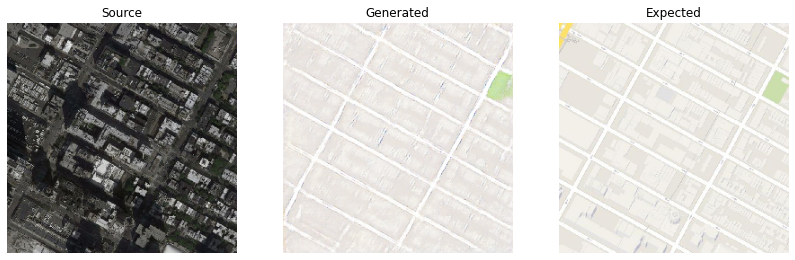

In [16]:
[X1, X2] = dataset
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = model.predict(src_image)

plt.figure(figsize=(14,8))
plot_images(src_image, gen_image, tar_image)

# Summary
pix2pix model is used to translate image from one domain to another. It was demonstrated how to train and convert satellite images to the corresponding maps images. The training is short (only 10 epochs), but already delivered promising results.

# References
- https://arxiv.org/abs/1611.07004
- https://phillipi.github.io/pix2pix/
- https://www.tensorflow.org/tutorials/generative/pix2pix
- https://github.com/bnsreenu/python_for_microscopists/tree/master/251_satellite_image_to_maps_translation